In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.compose import make_column_selector as selector #Para seleccionar de forma automática las variables numéricas y categóricas
from sklearn.preprocessing import OneHotEncoder #Para codificar las variables categóricas usando dummies
from sklearn.preprocessing import StandardScaler #Para normalizar las variables numéricas
from sklearn.compose import ColumnTransformer #Modifica las columnas usando los preprocesadores
from sklearn.pipeline import make_pipeline #Planifica una secuencia de procesos
from sklearn import set_config #Para mostrar graficamente el pipeline
from sklearn.model_selection import GridSearchCV

set_config(display='diagram')
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

df = pd.read_csv('../../data/Accidentes_2013_2023.csv')
df

,año,fall_les,tipo_veh,modelo_veh,g_modelo_veh,marca,color,hora_ocu_fall,g_hora_fall,g_hora_5_fall,día_sem_ocu_fall,mes_ocu_fall,causa_acc
0,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
1,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
2,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
3,2013,Fallecido,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
4,2013,Lesionado,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99510,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99511,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99512,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99513,2020,Fallecido,Motocicleta,2019,2010-2019,MRT,Rojo,18,18:00 a 23:59,Noche,Jueves,Diciembre,Atropello


# Limpieza de datos

In [15]:
# Reemplazar NaN por 'Ignorado' en la columna 'fall_les'
df['fall_les'] = df['fall_les'].fillna('Ignorado')

# Confirmar que ya no hay NaNs
print("Valores faltantes por columna después de reemplazar:")
print(df.isna().sum())

print("\nDistribución de clases en 'fall_les':")
print(df['fall_les'].value_counts())

Valores faltantes por columna después de reemplazar:
año                 0
fall_les            0
tipo_veh            0
modelo_veh          0
 g_modelo_veh       0
marca               0
color               0
hora_ocu_fall       0
g_hora_fall         0
g_hora_5_fall       0
día_sem_ocu_fall    0
mes_ocu_fall        0
causa_acc           0
dtype: int64

Distribución de clases en 'fall_les':
fall_les
Lesionado    64038
Ignorado     22566
Fallecido    12911
Name: count, dtype: int64


In [16]:
y = df.pop("fall_les")

print(y)
print(df.head())

0        Lesionado
1        Lesionado
2        Lesionado
3        Fallecido
4        Lesionado
           ...    
99510    Lesionado
99511    Lesionado
99512    Lesionado
99513    Fallecido
99514    Lesionado
Name: fall_les, Length: 99515, dtype: object
    año     tipo_veh modelo_veh  g_modelo_veh       marca   color  \
0  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
1  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
2  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
3  2013  Motocicleta  2010-2019      ignorado  Great Wall    Rojo   
4  2013  Motocicleta  2010-2019      ignorado  Great Wall    Rojo   

  hora_ocu_fall    g_hora_fall g_hora_5_fall día_sem_ocu_fall mes_ocu_fall  \
0             5  00:00 a 05:59      ignorado           Martes        Enero   
1             5  00:00 a 05:59      ignorado           Martes        Enero   
2             5  00:00 a 05:59      ignorado           Martes        Enero   
3      Ignorado  00

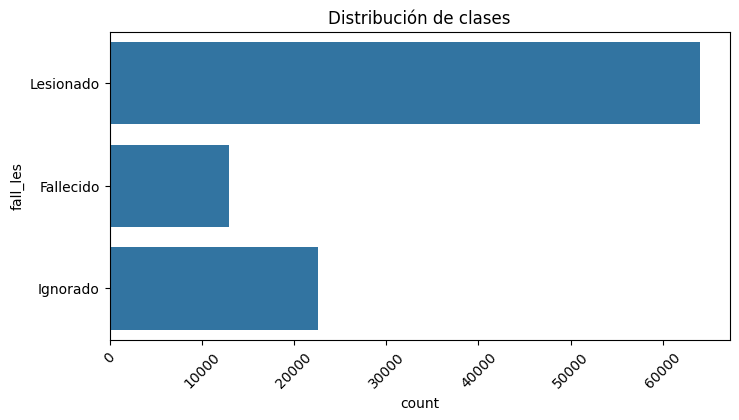

In [17]:
# Evaluar desbalance de clases
plt.figure(figsize=(8, 4))
sns.countplot(y)
plt.title("Distribución de clases")
plt.xticks(rotation=45)
plt.show()

# Entrenamiento y Pruebas

In [18]:
X = df #El resto de los datos

# Dividir train/test
random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Columnas categóricas y numéricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [19]:
print("Clases en entrenamiento:")
print(y_train.value_counts(normalize=True))

Clases en entrenamiento:
fall_les
Lesionado    0.643497
Ignorado     0.226759
Fallecido    0.129744
Name: proportion, dtype: float64


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69660 entries, 83086 to 5207
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   año               69660 non-null  int64 
 1   tipo_veh          69660 non-null  object
 2   modelo_veh        69660 non-null  object
 3    g_modelo_veh     69660 non-null  object
 4   marca             69660 non-null  object
 5   color             69660 non-null  object
 6   hora_ocu_fall     69660 non-null  object
 7   g_hora_fall       69660 non-null  object
 8   g_hora_5_fall     69660 non-null  object
 9   día_sem_ocu_fall  69660 non-null  object
 10  mes_ocu_fall      69660 non-null  object
 11  causa_acc         69660 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.9+ MB


In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29855 entries, 93586 to 81498
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   año               29855 non-null  int64 
 1   tipo_veh          29855 non-null  object
 2   modelo_veh        29855 non-null  object
 3    g_modelo_veh     29855 non-null  object
 4   marca             29855 non-null  object
 5   color             29855 non-null  object
 6   hora_ocu_fall     29855 non-null  object
 7   g_hora_fall       29855 non-null  object
 8   g_hora_5_fall     29855 non-null  object
 9   día_sem_ocu_fall  29855 non-null  object
 10  mes_ocu_fall      29855 non-null  object
 11  causa_acc         29855 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.0+ MB


# Buscar mejores parametros para las redes neuronales

### Al estar desbalanceados los datos, les haremos un sampling solo al conjunto de entrenamiento, utilizando SMOTE (Syntethic Minority Over-sampling)

- Oversampling sintético: SMOTE generó datos sintéticos (nuevos ejemplos artificiales) para las clases minoritarias ("Fallecido" e "Ignorado") hasta que tuvieron la misma cantidad que la clase mayoritaria ("Lesionado").
- El algoritmo no copia datos existentes, sino que interpola entre vecinos más cercanos en el espacio de características para crear nuevas muestras plausibles de esas clases.

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline completo con SMOTE
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('mlpclassifier', MLPClassifier())
])

# 5. Grid de parámetros
parametros_tun = {
    'mlpclassifier__max_iter': [100, 200, 500],
    'mlpclassifier__learning_rate_init': [0.01, 0.1, 1],
    'mlpclassifier__hidden_layer_sizes': [(3, 2), (5, 3), (10, 2)]
}

# 6. GridSearchCV
model_grid_search = GridSearchCV(pipeline, param_grid=parametros_tun, n_jobs=2, cv=10, verbose=1)
model_grid_search.fit(X_train, y_train)

# 7. Mejor modelo y predicciones
print("Mejores parámetros:", model_grid_search.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejores parámetros: {'mlpclassifier__hidden_layer_sizes': (5, 3), 'mlpclassifier__learning_rate_init': 0.01, 'mlpclassifier__max_iter': 500}


# Verificacion del sampling

In [21]:
best_model = model_grid_search.best_estimator_

X_train_preprocessed = best_model.named_steps['preprocessor'].fit_transform(X_train)
y_train_array = np.array(y_train)

X_smote, y_smote = best_model.named_steps['smote'].fit_resample(X_train_preprocessed, y_train_array)

# Revisar balance resultante
print("Distribución después de SMOTE dentro del pipeline:")
print(pd.Series(y_smote).value_counts())

Distribución después de SMOTE dentro del pipeline:
Ignorado     44826
Fallecido    44826
Lesionado    44826
Name: count, dtype: int64


## Validacion cruzada

In [28]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

cv_results = cross_validate(best_model, X, y, cv=cv, scoring=scoring)

print("\nValidación cruzada (10-fold):")
print("Accuracy promedio:", np.mean(cv_results['test_accuracy']))
print("Precision promedio:", np.mean(cv_results['test_precision_macro']))
print("Recall promedio:", np.mean(cv_results['test_recall_macro']))
print("F1-score promedio:", np.mean(cv_results['test_f1_macro']))


Validación cruzada (10-fold):
Accuracy promedio: 0.7558040942014584
Precision promedio: 0.7472436315203137
Recall promedio: 0.7892184705152372
F1-score promedio: 0.7327352045803541


## Entrenarlo

In [30]:
y_pred = best_model.predict(X_test)
print(y_pred)

['Fallecido' 'Lesionado' 'Ignorado' ... 'Lesionado' 'Lesionado' 'Ignorado']


# Curva de perdida

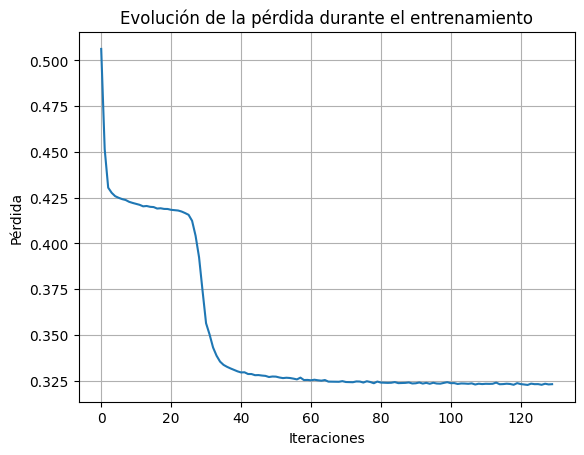

In [31]:
plt.plot(best_model.named_steps['mlpclassifier'].loss_curve_)
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

# Matriz de confusion

Accuracy:  0.8081728353709596 

              precision    recall  f1-score   support

   Fallecido       0.36      0.61      0.45      3873
    Ignorado       1.00      1.00      1.00      6770
   Lesionado       0.91      0.78      0.84     19212

    accuracy                           0.81     29855
   macro avg       0.76      0.80      0.76     29855
weighted avg       0.86      0.81      0.83     29855



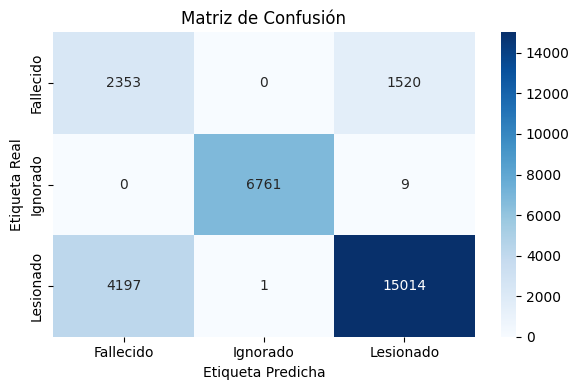

In [35]:
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy: ',accuracy, '\n')
print(classification_report(y_test, y_pred))

labels = best_model.classes_  # Obtiene los nombres de las clases desde el modelo

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
plt.show()

In [36]:
# Evaluación del fitting: comparar accuracy en train y test
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print("Accuracy en entrenamiento:", train_acc)
print("Accuracy en test:", test_acc)
diff = abs(train_acc - test_acc)

# Evaluar si hay underfitting o overfitting
if train_acc < 0.7 and test_acc < 0.7:
    print("❗ Underfitting: El modelo tiene bajo rendimiento tanto en entrenamiento como en prueba.")
elif train_acc - test_acc > 0.1:
    print("⚠️ Overfitting: El modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien.")
else:
    print("✅ Buen ajuste: El modelo generaliza correctamente con una diferencia razonable entre entrenamiento y prueba.")

Accuracy en entrenamiento: 0.821159919609532
Accuracy en test: 0.8081728353709596
✅ Buen ajuste: El modelo generaliza correctamente con una diferencia razonable entre entrenamiento y prueba.


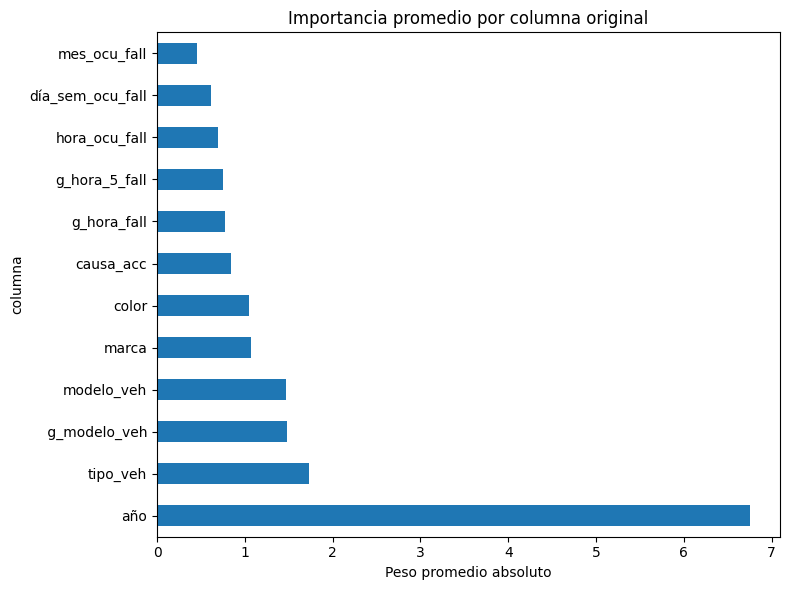

In [37]:
from collections import defaultdict

# Obtener nombres completos de features (numéricas + dummies)
dummy_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(dummy_names)

# Obtener pesos de la primera capa
coefs = best_model.named_steps['mlpclassifier'].coefs_[0]

# Calcular media absoluta de los pesos por feature individual
feature_weights = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_weight': np.abs(coefs).mean(axis=1)
})

# Agrupar por columna original
col_importance = defaultdict(list)

for feat, weight in zip(feature_weights['feature'], feature_weights['mean_abs_weight']):
    for col in cat_cols:
        if feat.startswith(col + '_'):
            col_importance[col].append(weight)
            break
    else:
        col_importance[feat].append(weight)  # numéricas

# Promediar por columna original
importancia_columnas = pd.DataFrame({
    'columna': list(col_importance.keys()),
    'importancia_promedio': [np.mean(v) for v in col_importance.values()]
}).sort_values('importancia_promedio', ascending=False)

# Graficar
importancia_columnas.plot(kind='barh', x='columna', y='importancia_promedio', figsize=(8, 6), legend=False)
plt.title("Importancia promedio por columna original")
plt.xlabel("Peso promedio absoluto")
plt.tight_layout()
plt.show()